# ASSIGNMENT

In a clean notebook, using the **Seattle Bicycle Weather** dataset, make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

In [1]:
# Loading tools needed
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [2]:
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [3]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [4]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [5]:
# Download and join data into a dataframe
data = load()

In [6]:
data.describe(include='number')

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


In [7]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [8]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [29]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth' : randint(1, 5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.9s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96212e0518>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96212e09e8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [10]:
print('Mean Absolute Error with Cross-Validation:')
print(f'Predictions are off by {int(-search.best_score_)} bicyclists per day, on average')

Mean Absolute Error with Cross-Validation:
Predictions are off by 265 bicyclists per day, on average


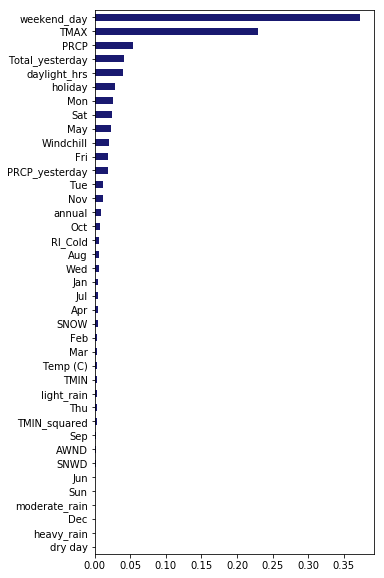

In [11]:
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='midnightblue');

In [12]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=99, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [13]:
X_test.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,...,Jul,Aug,Sep,Oct,Nov,Dec,light_rain,moderate_rain,heavy_rain,weekend_day
2015-05-25,0.0,0,0,15.6,11.1,27,1776.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2015-05-26,0.0,0,0,21.7,11.7,21,1737.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2015-05-27,0.0,0,0,24.4,11.7,18,4254.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2015-05-28,0.0,0,0,27.8,12.2,21,4771.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2015-05-29,0.0,0,0,26.1,12.8,25,5142.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


In [14]:
y_test.head()

2015-05-25    1737.0
2015-05-26    4254.0
2015-05-27    4771.0
2015-05-28    5142.0
2015-05-29    4548.0
Name: Total, dtype: float64

In [15]:
final = search.best_estimator_
y_pred = final.predict(X_test) # We already wrangled X_test in the same way as X_train
test_mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error, with final model, on the hold-out test set:', test_mae)

Mean Absolute Error, with final model, on the hold-out test set: 252.56884338378907


In [16]:
print('Mean Absolute Error with Cross-Validation:', -search.best_score_)

Mean Absolute Error with Cross-Validation: 265.83134640290604


In [17]:
best = -search.best_score_

In [18]:
best

265.83134640290604

In [19]:
# convert DataFrames to numpy matrices (2d)
X_train_dbg = X_train.as_matrix()
y_train_dbg = y_train.as_matrix()
X_test_dbg = X_test.as_matrix()
y_test_dbg = y_test.as_matrix()

final.fit(X_train_dbg, y_train_dbg) 
perm = PermutationImportance(final).fit(X_test_dbg, y_test_dbg)

eli5.show_weights(perm)
# works fine

Weight,Feature
0.9825 ± 0.1559,x38
0.0963 ± 0.0187,x0
0.0515 ± 0.0140,x3
0.0477 ± 0.0102,x6
0.0411 ± 0.0160,x14
0.0341 ± 0.0167,x11
0.0135 ± 0.0117,x27
0.0109 ± 0.0037,x8
0.0099 ± 0.0035,x12
0.0079 ± 0.0045,x4


In [20]:
permuter = PermutationImportance(perm, scoring='neg_mean_absolute_error',
                     n_iter=5, random_state=42)

permuter.fit(X_test, y_test)

PermutationImportance(cv='prefit',
           estimator=PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estima... silent=True,
       subsample=1),
           n_iter=5, random_state=None, refit=True, scoring=None),
           n_iter=5, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [21]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
586.6449 ± 88.0890,weekend_day
92.0651 ± 51.1367,PRCP
70.8174 ± 30.6084,TMAX
56.4402 ± 27.6623,Total_yesterday
46.1962 ± 11.6491,Fri
23.4272 ± 12.9499,holiday
20.2299 ± 11.6066,Tue
18.6009 ± 2.1396,Sat
13.2992 ± 2.5554,PRCP_yesterday
11.0555 ± 10.7381,May


In [23]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (963, 39)


In [24]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (963, 20)


In [32]:

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


ValueError: multiclass format is not supported

In [31]:
best = search.best_estimator_
X_test = X_test[features]
y_pred_proba = best.predict_proba(X_test)[:,1]

AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'